# Hands-On

Welcome the the hands-on exercises. All exercises can be solved using this jupyter notebook. Make sure jupyter notebook is launched in the root folder of the gpu-mangrove_exercises repository (otherwise relative paths to the files are not correct).

This notebook is divided into three sections:
1. Building and executing benchmarks
2. Review of the benchmarking results
3. Prediction of time and power consumptions

There is as [`solution`](/tree/solution) folder where you can get intermediate results, if you need them.

Here some css to highlight code blocks better and to get a wide column for the jupyter notebook. It has only visual effects and does not need to be executed.

In [ ]:
%%html
<style>
.container { width:100% !important; }
.rendered_html pre code {border: 0; background-color: #f4f4f4; display:inline-block;}
.rendered_html code.language-cpp {border: 0; background-color: #f4f4f4; display:inline-block;}
</style>

# Task 1.1 - Implement Time Measurements and Instrumentation

1. Edit [`benchmarks/time_instrumentation/common/instrumentation.h`](/edit/benchmarks/time_instrumentation/common/instrumentation.h) (you can click on the link to edit the file)
    * Use `gettimeofday` to measure time. Here en example on how to use it:
```cpp
struct timeval mytime;
gettimeofday(&mytime, NULL);
unsigned long time1 = (unsigned long)mytime.tv_sec * 1e6 + (unsigned long)mytime.tv_usec;
/* Some other code */
unsigned long time2 = (unsigned long)mytime.tv_sec * 1e6 + (unsigned long)mytime.tv_usec;
unsigned long diff = time2 - time1;
```
    * make sure the kernel finished before measuring time after kernel launch
2. Insert `PRE_KERNEL` and `POST_KERNEL` before and after each kernel launch in the [benchmarks](tree/benchmarks/time_instrumentation).  
   Example:
```cpp
PRE_KERNEL
vectorAdd<<<grid_size,block_size>>>(A,B,C);
POST_KERNEL
```
3. Compile the benchmarks in cuda_flux and time_instrumentation after completing the tasks.

In [1]:
%%bash
module load cuda llvm cuda-flux 
cd benchmarks/time_instrumentation && make

cd kmeans && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/kmeans'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/kmeans'
cd 5p-stencil && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/5p-stencil'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/5p-stencil'
cd 2DCONV && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/2DCONV'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/2DCONV'
cd ATAX && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/time_instrumentation/ATAX'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/hom

# Task 1.2 - Build power instrumentation binaries

View [`benchmarks/power_instrumentation/common/instrumentation.h`](/edit/benchmarks/power_instrumentation/common/instrumentation.h) you need to define the PRE_KERNEL and POST_KERNEL macros in line XX and YY. Multiple lines can be defined like this:

```cpp
#define MYMACRO std::cout << "Hello "; \
                std::cout << "World!\n"; \
                std::cout << "Good bye\n";
```

When measuring power the kernel should be executed in a loop until a time threshold is reached. One second usually works fine. To check if the time is really up the kernel must be finished after each iteration ( use cudaDeviceSynchronize(); *hint hint*).

A loop which will be executet until at least one second is reached could be implemented like this:

```cpp
for (auto start = std::chrono::steady_clock::now(),
     nvml_now = start; nvml_now < start + std::chrono::milliseconds{1000};
     nvml_now = std::chrono::steady_clock::now()) {
    /* loop body */
}
```

# Task 1.3- Add additional workloads for the benchmarks

1. Edit [measurements/my_benchmarks/app_arguments.txt](/edit/measurements/my_benchmarks/app_arguments.txt) and add more workloads
    Syntax is as follows:
    ```
    <executable> <workload name> <arguments>
    ```
    Example
    ```
    n-body 1k-bodies 1024
    n-body 2k-bodies 2048
    ```
2. Update [measurements/benchmarks_lists/my_benchmarks.yaml](/edit/measurements/benchmark_lists/my_benchmarks.yaml). Add the workload names you created for each benchmark. 
    The result could look like this: 
    ```
    n-body [1k-bodies, 2k-bodies]
    ```
    * Try to use at least four different workloads for each application.
    * Test how large the workload can be, without running out of memory on the GPU.
    * The largest pre-defined workload should fit within 4GB.

# Task 1.4 - Execute the Benchmarks

1. Execute `prepare_measurements.sh`. It will copy the binaries to the benchmark folder

In [2]:
%%bash
module load cuda llvm cuda-flux
./prepare_measurements.sh

building cuda flux binaries..
cd kmeans && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/kmeans'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/kmeans'
cd 5p-stencil && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/5p-stencil'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/5p-stencil'
cd 2DCONV && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/2DCONV'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/2DCONV'
cd ATAX && make
make[1]: Entering directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda_flux/ATAX'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/home/lbraun/gpu-mangrove_exercises/benchmarks/cuda

2. Go to the measurements folder and create scripts for your measurements:

In [3]:
%%bash
# TODO make sure scripts are executable (no python3 needed)
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements

# Create script measuring time with 10 iterations on the K80 GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'time_K80' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b time -t time_K80 -i 10 -q 'srun --partition=K80' > time_measurements_K80.sh

# Create script measuring time with 10 iterations on the K80 GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'time_K80' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b time -t time_T4 -i 10 -q 'srun --partition=T4' > time_measurements_T4.sh

# Create script measuring time with 10 iterations on the K80 GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'time_K80' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b power -t power_K80 -i 10 -q 'srun --partition=K80' > power_measurements_K80.sh

# Create script measuring time with 10 iterations on the K80 GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'time_K80' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b power -t power_T4 -i 10 -q 'srun --partition=T4' > power_measurements_T4.sh

# Create script measuring kernel metrics on any GPU using the benchmarks in benchmark_lists/my_benchmarks.yaml
# -t creates the tag 'flux' for filtering purposes when processing the results
./scheduler.py -l benchmark_lists/my_benchmarks.yaml \
-b flux -t flux -i 1 -q 'srun' > cuda_flux_measurements.sh

echo Created benchmark scripts:
ls *_measurements*.sh

Created benchmark scripts:
cuda_flux_measurements.sh
power_measurements_K80.sh
power_measurements_T4.sh
time_measurements_K80.sh
time_measurements_T4.sh


./scheduler.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(args.list))
./scheduler.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(args.list))
./scheduler.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(args.list))
./scheduler.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(args.list))
./scheduler.py:25: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read h

3. Execute the generated scripts.

In [ ]:
%%bash
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements

# Run cuda flux measurements on any GPU
bash cuda_flux_measurements.sh

**Please run time and power measuring only on either the K80 or the T4 GPU.**  
There is only an limited number of GPUs available and running the measurement on both GPU will take much more time to finish for everyone.

In [ ]:
%%bash
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements

# Run time measurements on a T4 GPU
bash time_measurements_T4.sh
# Run time measurements on a T4 GPU
#bash time_measurements_K80.sh

In [ ]:
%%bash
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements

# Run power measurements on a T4 GPU
bash power_measurements_T4.sh
# Run power measurements on a T4 GPU
#bash power_measurements_K80.sh

# Task 2.1- Process the Measurement Results

Stay in the folder measurements and process the measurement results:

In [4]:
%%bash
# TODO make sure scripts are executable (no python3 needed)
module load cuda llvm cuda-flux
source /opt/py_env/bin/activate
cd measurements
rm -f cuda_flux_metrics.db kernel_time_K80.db kernel_time_T4.db kernel_power_T4.db kernel_power_K80.db
python3 processing/extractCUDAFluxMetrics.py -logdir log -tag flux -o cuda_flux_metrics.db
python3 processing/extractKernelTime.py -logdir log -tag time_K80 -o kernel_time_K80.db
python3 processing/extractKernelTime.py -logdir log -tag time_T4 -o kernel_time_T4.db
python3 processing/extractKernelPower.py -logdir log -tag power_T4 -o kernel_power_T4.db
python3 processing/extractKernelPower.py -logdir log -tag power_K80 -o kernel_power_K80.db

Namespace(logdir='log', o='cuda_flux_metrics.db', tag='flux')
Processing my_benchmarks 5p-stencil s4
('log/c68b/20210118-082827.702549_g4dn01_5p-stencil',)
Processing my_benchmarks gemm s2
('log/20ab/20210118-082933.871126_g4dn01_gemm',)
Processing my_benchmarks 5p-stencil_opt s2
('log/06dd/20210118-082846.423675_g4dn01_5p-stencil_opt',)
Processing my_benchmarks mvt s3
('log/b8a0/20210118-082939.705284_g4dn01_mvt',)
Processing my_benchmarks 5p-stencil s1
('log/5606/20210118-082822.875486_g4dn01_5p-stencil',)
Processing my_benchmarks gemm s4
('log/89c9/20210118-082935.790851_g4dn01_gemm',)
Processing my_benchmarks gemm s3
('log/84af/20210118-082934.750441_g4dn01_gemm',)
Processing my_benchmarks mvt s4
('log/cf48/20210118-082941.082524_g4dn01_mvt',)
Processing my_benchmarks 5p-stencil_opt s4
('log/1762/20210118-082849.454098_g4dn01_5p-stencil_opt',)
Processing my_benchmarks kmeans s2
('log/7486/20210118-082904.878451_g4dn01_kmeans',)
Processing my_benchmarks 2DConvolution s1
('log/9064/2

processing/extractCUDAFluxMetrics.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  doc = yaml.load(open(filepath, 'r'))


# Task 2.2 - Examine the Results

## CUDA Flux

The metric CUDA Flux provides are stored in `measurement/cuda_flux_metrics.db`. The following sql-queries show the table layout and the metrics CUDA Flux provides:

In [5]:
%%bash
echo 'Table Layout:'
sqlite3 measurements/cuda_flux_metrics.db .schema
echo 'CUDA Flux Metrics:'
sqlite3 measurements/cuda_flux_metrics.db 'select distinct(metric) from fluxmetrics;'

Table Layout:
CREATE TABLE fluxmetrics
                    (bench text not null,
                    app text not null,
                    dataset text not null,
                    lseq integer not null,
                    name text not null,
                    metric text not null,
                    value double not null);
CUDA Flux Metrics:
gX
gY
gZ
bX
bY
bZ
shm
time
ld.param.u32
mov.u32
mad.lo.s32
add.s32
mul.lo.s32
setp.ge.s32
bra
ld.param.u64
cvta.to.global.u64
mul.wide.s32
div.s32
shl.b32
add.s64
ld.global.f32
fma.rn.f32
add.rn.f32
setp.gt.f32
selp.f32
setp.lt.f32
st.global.f32
setp.lt.s32
ret
cvt.u64.u32
setp.ge.u64
cvt.s64.s32
mul.lo.s64
shl.b64
mul.rn.f32
and.b64
setp.lt.u64
mov.u64
setp.ne.s64
cvt.u32.u64
setp.eq.s64
sub.s32
or.pred
add.u64
setp.eq.s32
bra.uni
bar.sync
setp.ne.s32
and.b32
ld.global.u32
mul.wide.u32
st.local.u32
st.shared.u32
setp.lt.u32
ld.local.f32
ld.shared.f32
setp.gt.s32
mov.f32
sqrt.rn.f32
selp.b32
sub.rn.f32
st.global.u32
div.u32
ld.shared.u32
ato

This example will show all table entries with the `bar.sync` metrics. This instruction is emitted when calling `__syncthreads();` in the kernel.

In [6]:
import pandas as pd
import sqlite3

with sqlite3.Connection('measurements/cuda_flux_metrics.db') as conn:
        df_features = pd.read_sql_query("select * from fluxmetrics", conn)

# Display all line with the metric bar.sync which is the __syncthreads(); function call.
df_features[df_features['metric'] == 'bar.sync']

# Uncomment to get complete table
# Setting to show complete table:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# df_features

,bench,app,dataset,lseq,name,metric,value
88,my_benchmarks,5p-stencil_opt,s2,0,_Z17optStencil_KerneliPfS_,bar.sync,8515584.0
344,my_benchmarks,5p-stencil_opt,s4,0,_Z17optStencil_KerneliPfS_,bar.sync,213012480.0
433,my_benchmarks,kmeans,s2,1,_Z19kmeans_centroid_sumPfPiS_S0_iii,bar.sync,2048.0
602,my_benchmarks,kmeans,s3,1,_Z19kmeans_centroid_sumPfPiS_S0_iii,bar.sync,10240.0
787,my_benchmarks,5p-stencil_opt,s3,0,_Z17optStencil_KerneliPfS_,bar.sync,136314880.0
1085,my_benchmarks,kmeans,s1,1,_Z19kmeans_centroid_sumPfPiS_S0_iii,bar.sync,1024.0
1328,my_benchmarks,5p-stencil_opt,s1,0,_Z17optStencil_KerneliPfS_,bar.sync,2127872.0
1403,my_benchmarks,5p-stencil_opt,s5,0,_Z17optStencil_KerneliPfS_,bar.sync,852090880.0


## Kernel Execution Time

In [7]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Replace T4 with K80 if you measured on the K80 GPU
with sqlite3.Connection('measurements/kernel_time_T4.db') as conn:
            df = pd.read_sql_query("select * from kerneltime", conn)
        
# Setting to show complete table:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
df

,bench,app,dataset,build,lseq,time
0,my_benchmarks,2DConvolution,s2,time,0,3273
1,my_benchmarks,2DConvolution,s2,time,0,3270
2,my_benchmarks,2DConvolution,s2,time,0,3280
3,my_benchmarks,2DConvolution,s2,time,0,3271
4,my_benchmarks,2DConvolution,s2,time,0,3270
...,...,...,...,...,...,...
425,my_benchmarks,mvt,s4,time,1,22337
426,my_benchmarks,mvt,s4,time,0,124915
427,my_benchmarks,mvt,s4,time,1,22351
428,my_benchmarks,mvt,s4,time,0,126686


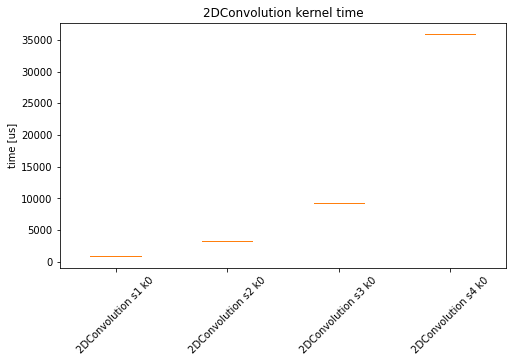

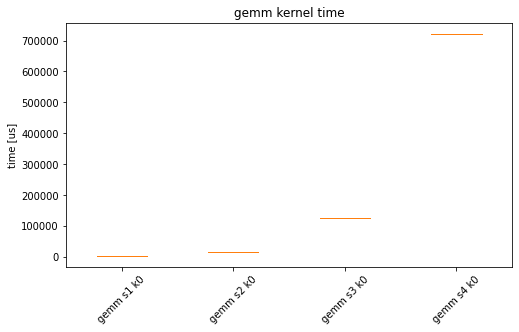

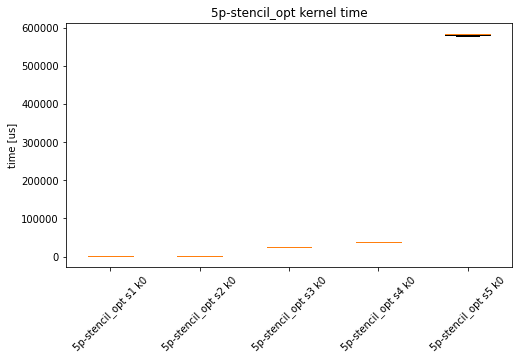

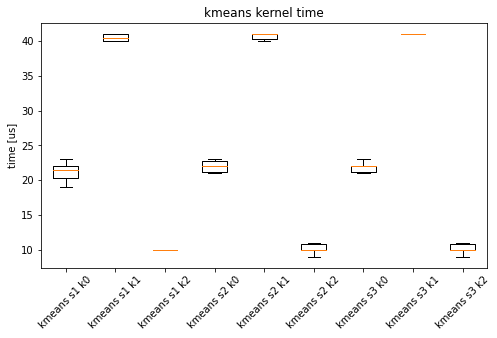

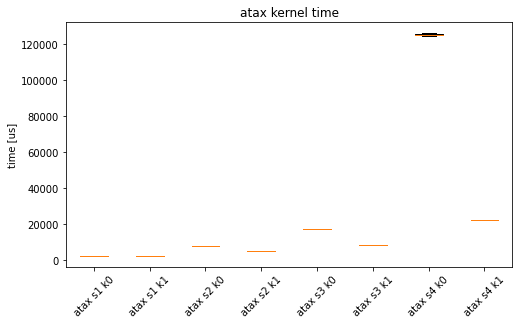

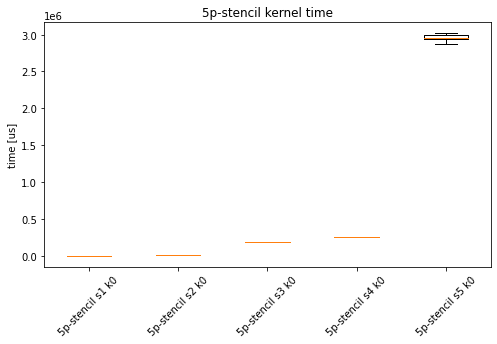

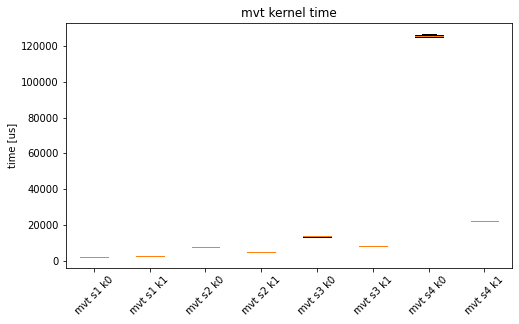

In [8]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Replace T4 with K80 if you measured on the K80 GPU
with sqlite3.Connection('measurements/kernel_time_T4.db') as conn:
            df = pd.read_sql_query("select * from kerneltime", conn)

for app in df['app'].unique():
    df_filtered=df[df['app'] == app]
    x_labels = []
    data = []
    for idx,values in df_filtered.groupby(['bench','app','dataset','lseq'])['time']:
        # application name + dataset name + kernel number (launch sequence)
        x_labels.append(idx[1]+' '+idx[2]+' k'+str(idx[3]))
        data.append(values.values)

    fig1, ax1 = plt.subplots(figsize=(8,4.5))
    #ax1.set_yscale('log')

    ax1.set_title(app + ' kernel time')
    ax1.set_ylabel('time [us]')
    res = ax1.boxplot(data, showfliers=False)
    ax1.set_xticklabels(x_labels)
    ax1.xaxis.set_tick_params(rotation=45)

## Power Consumption

In [9]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Replace T4 with K80 if you measured on the K80 GPU
with sqlite3.Connection('measurements/kernel_power_T4.db') as conn:
            df = pd.read_sql_query("select * from kernelpower", conn)
        
# Setting to show complete table:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
df

,bench,app,dataset,build,lseq,power
0,my_benchmarks,gemm,s1,power,0,61.6013
1,my_benchmarks,gemm,s1,power,0,61.5754
2,my_benchmarks,gemm,s1,power,0,61.4874
3,my_benchmarks,gemm,s1,power,0,61.8093
4,my_benchmarks,gemm,s1,power,0,61.3519
...,...,...,...,...,...,...
425,my_benchmarks,gemm,s3,power,0,62.9315
426,my_benchmarks,gemm,s3,power,0,63.1278
427,my_benchmarks,gemm,s3,power,0,63.1501
428,my_benchmarks,gemm,s3,power,0,63.1251


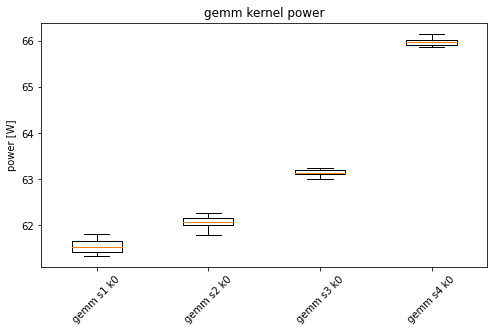

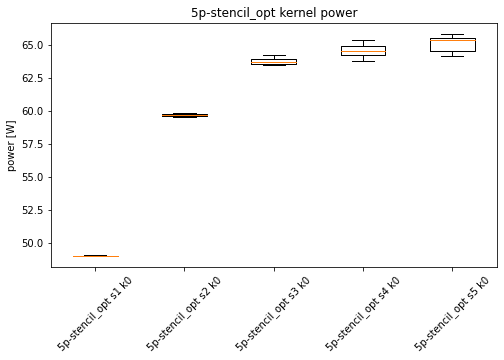

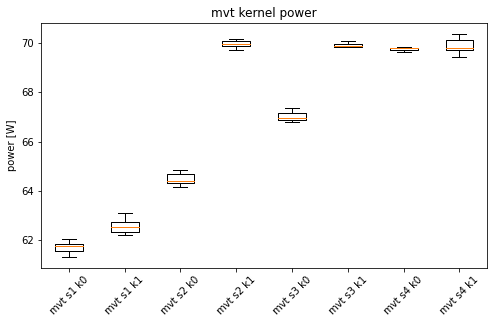

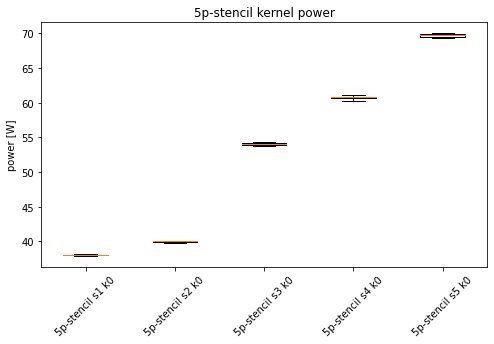

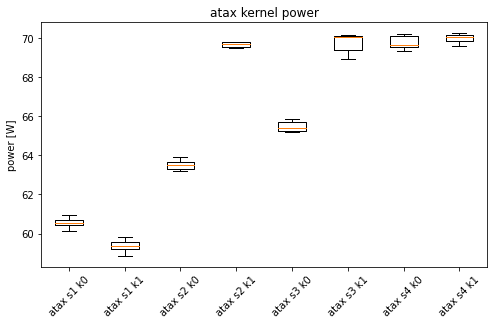

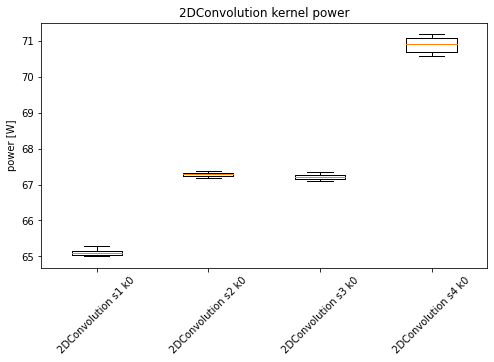

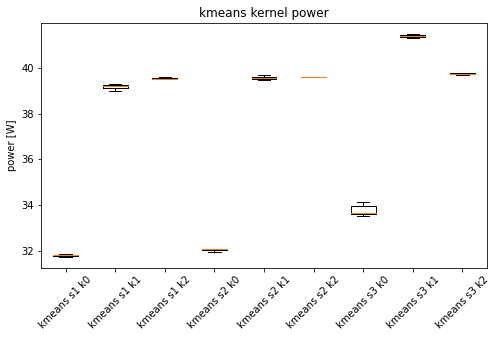

In [11]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Replace T4 with K80 if you measured on the K80 GPU
with sqlite3.Connection('measurements/kernel_power_T4.db') as conn:
            df = pd.read_sql_query("select * from kernelpower", conn)

for app in df['app'].unique():
    df_filtered=df[df['app'] == app]
    x_labels = []
    data = []
    for idx,values in df_filtered.groupby(['bench','app','dataset','lseq'])['power']:
        # application name + dataset name + kernel number (launch sequence)
        x_labels.append(idx[1]+' '+idx[2]+' k'+str(idx[3]))
        data.append(values.values)

    fig1, ax1 = plt.subplots(figsize=(8,4.5))
    #ax1.set_yscale('log')

    ax1.set_title(app + ' kernel power')
    ax1.set_ylabel('power [W]')
    res = ax1.boxplot(data, showfliers=False)
    ax1.set_xticklabels(x_labels)
    ax1.xaxis.set_tick_params(rotation=45)

# Coffee Break ☕

# Task 3.1 - Build datasets using GPU Mangrove
    
**Execute `init_gpu_mangrove.sh` and go to the gpu mangrove folder**

In [ ]:
%%bash
./init_gpu_mangrove.sh

**Convert the CUDA Flux metrics:**

In [12]:
%%bash
cd gpu-mangrove
source /opt/py_env/bin/activate
rm -f my_model_features.db
./mangrove.py convert -i ../measurements/cuda_flux_metrics.db -o my_model_features.db

Processing Items..


100%|██████████| 31/31 [00:00<00:00, 1067.41it/s]


## Merge features with time measurements to create a sample dataset

In [13]:
%%bash
cd gpu-mangrove
source /opt/py_env/bin/activate
rm -f data/time_samples_T4.db
./mangrove.py process --fdb my_model_features.db --mdb ../measurements/kernel_time_T4.db -o data/time_samples_T4.db

Processing DBs


Inspect the sample database.

In [14]:
import pandas as pd
import sqlite3

# Replace T4 with K80 if you measured on the K80 GPU
with sqlite3.Connection('gpu-mangrove/data/time_samples_T4.db') as conn:
            df = pd.read_sql_query("select * from samples", conn)
        
df

,index,bench,app,dataset,name,threads_per_CTA,CTAs,total_instructions,special_operations,logic_operations,control_operations,arithmetic_operations,sync_operations,global_memory_volume,param_memory_volume,shared_memory_volume,arithmetic_intensity,time
0,0,my_benchmarks,2DConvolution,s1,_Z20Convolution2D_kernelPfS_m,256.0,65536.0,1.039483e+09,0.0,8.382875e+07,5.032755e+07,6.874195e+08,0.0,6.704334e+08,4.023911e+08,0.000000e+00,0.640757,840.5
1,1,my_benchmarks,2DConvolution,s2,_Z20Convolution2D_kernelPfS_m,256.0,262144.0,4.159341e+09,0.0,3.354296e+08,2.013184e+08,2.750571e+09,0.0,2.683044e+09,1.610089e+09,0.000000e+00,0.640691,3271.5
2,2,my_benchmarks,2DConvolution,s3,_Z20Convolution2D_kernelPfS_m,256.0,1048576.0,1.664018e+10,0.0,1.341948e+09,8.052900e+08,1.100407e+10,0.0,1.073480e+10,6.441402e+09,0.000000e+00,0.640658,9325.5
3,3,my_benchmarks,2DConvolution,s4,_Z20Convolution2D_kernelPfS_m,256.0,4194304.0,6.656636e+10,0.0,5.368250e+09,3.221193e+09,4.401984e+10,0.0,4.294443e+10,2.576771e+10,0.000000e+00,0.640641,35906.5
4,4,my_benchmarks,5p-stencil,s1,_Z20simpleStencil_KerneliPfS_,128.0,9.0,2.721541e+08,0.0,8.778532e+06,8.780836e+06,2.019201e+08,0.0,2.106848e+08,2.304000e+04,0.000000e+00,0.958294,5462.5
5,5,my_benchmarks,5p-stencil,s2,_Z20simpleStencil_KerneliPfS_,128.0,17.0,1.947003e+09,0.0,6.280537e+07,6.280972e+07,1.444550e+09,0.0,1.507329e+09,4.352000e+04,0.000000e+00,0.958323,20324.5
6,6,my_benchmarks,5p-stencil,s3,_Z20simpleStencil_KerneliPfS_,128.0,66.0,9.054316e+10,0.0,2.920742e+09,2.920759e+09,6.717718e+10,0.0,7.009782e+10,1.689600e+05,0.000000e+00,0.958332,194325.5
7,7,my_benchmarks,5p-stencil,s4,_Z20simpleStencil_KerneliPfS_,128.0,82.0,1.623961e+11,0.0,5.238579e+09,5.238600e+09,1.204874e+11,0.0,1.257259e+11,2.099200e+05,0.000000e+00,0.958333,258788.0
8,8,my_benchmarks,5p-stencil,s5,_Z20simpleStencil_KerneliPfS_,128.0,163.0,9.320321e+11,0.0,3.006554e+10,3.006558e+10,6.915077e+11,0.0,7.215730e+11,4.172800e+05,0.000000e+00,0.958333,2959377.0
9,9,my_benchmarks,5p-stencil_opt,s1,_Z17optStencil_KerneliPfS_,128.0,9.0,5.682289e+07,0.0,5.283080e+06,4.239635e+06,3.571036e+07,2127872.0,8.433680e+06,2.123200e+04,2.096749e+07,4.223623,1020.0


Here an example plot showing the number of instructions of each sample.

`total_instructions` can be replaced by any of these other features:
* threads_per_CTA
* CTAs
* total_instructions
* special_operations
* logic_operations
* control_operations
* arithmetic_operations
* sync_operations
* global_memory_volume
* param_memory_volume
* shared_memory_volume'
* arithmetic_intensity
* time/power

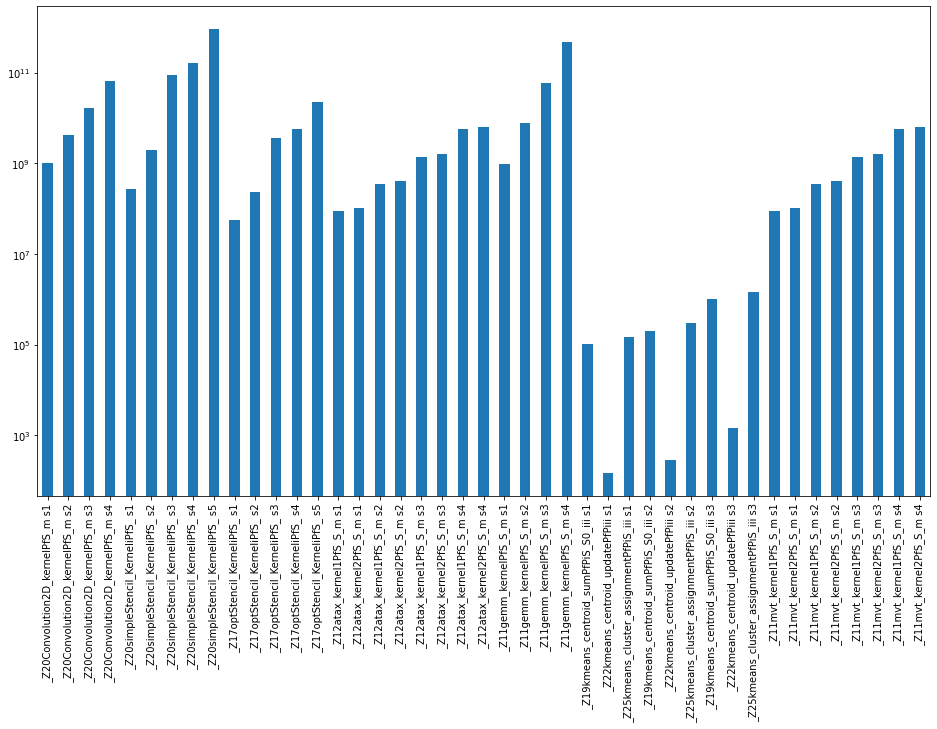

In [15]:
import pandas as pd
import sqlite3

# Replace T4 with K80 if you measured on the K80 GPU
with sqlite3.Connection('gpu-mangrove/data/time_samples_T4.db') as conn:
            df = pd.read_sql_query("select * from samples", conn)

df['total_instructions'].plot.bar(figsize=(16,9))
loc, labels = plt.xticks()
plt.yscale('log')
res = plt.xticks(loc, df['name']+' '+df['dataset'], rotation=90)

This processes the power samples of the T4 GPU

## Merge features with power measurements to create a sample dataset

In [16]:
%%bash
cd gpu-mangrove
source /opt/py_env/bin/activate
rm -f data/power_samples_T4.db
./mangrove.py process --fdb my_model_features.db --mdb ../measurements/kernel_power_T4.db -o data/power_samples_T4.db

Processing DBs


In [17]:
import pandas as pd
import sqlite3

# Replace T4 with K80 if you measured on the K80 GPU
with sqlite3.Connection('gpu-mangrove/data/power_samples_T4.db') as conn:
            df = pd.read_sql_query("select * from samples", conn)
        
df

,index,bench,app,dataset,name,threads_per_CTA,CTAs,total_instructions,special_operations,logic_operations,control_operations,arithmetic_operations,sync_operations,global_memory_volume,param_memory_volume,shared_memory_volume,arithmetic_intensity,power
0,0,my_benchmarks,2DConvolution,s1,_Z20Convolution2D_kernelPfS_m,256.0,65536.0,1.039483e+09,0.0,8.382875e+07,5.032755e+07,6.874195e+08,0.0,6.704334e+08,4.023911e+08,0.000000e+00,0.640757,65.09795
1,1,my_benchmarks,2DConvolution,s2,_Z20Convolution2D_kernelPfS_m,256.0,262144.0,4.159341e+09,0.0,3.354296e+08,2.013184e+08,2.750571e+09,0.0,2.683044e+09,1.610089e+09,0.000000e+00,0.640691,67.30685
2,2,my_benchmarks,2DConvolution,s3,_Z20Convolution2D_kernelPfS_m,256.0,1048576.0,1.664018e+10,0.0,1.341948e+09,8.052900e+08,1.100407e+10,0.0,1.073480e+10,6.441402e+09,0.000000e+00,0.640658,67.20570
3,3,my_benchmarks,2DConvolution,s4,_Z20Convolution2D_kernelPfS_m,256.0,4194304.0,6.656636e+10,0.0,5.368250e+09,3.221193e+09,4.401984e+10,0.0,4.294443e+10,2.576771e+10,0.000000e+00,0.640641,70.90965
4,4,my_benchmarks,5p-stencil,s1,_Z20simpleStencil_KerneliPfS_,128.0,9.0,2.721541e+08,0.0,8.778532e+06,8.780836e+06,2.019201e+08,0.0,2.106848e+08,2.304000e+04,0.000000e+00,0.958294,38.02105
5,5,my_benchmarks,5p-stencil,s2,_Z20simpleStencil_KerneliPfS_,128.0,17.0,1.947003e+09,0.0,6.280537e+07,6.280972e+07,1.444550e+09,0.0,1.507329e+09,4.352000e+04,0.000000e+00,0.958323,40.00380
6,6,my_benchmarks,5p-stencil,s3,_Z20simpleStencil_KerneliPfS_,128.0,66.0,9.054316e+10,0.0,2.920742e+09,2.920759e+09,6.717718e+10,0.0,7.009782e+10,1.689600e+05,0.000000e+00,0.958332,54.04010
7,7,my_benchmarks,5p-stencil,s4,_Z20simpleStencil_KerneliPfS_,128.0,82.0,1.623961e+11,0.0,5.238579e+09,5.238600e+09,1.204874e+11,0.0,1.257259e+11,2.099200e+05,0.000000e+00,0.958333,60.74810
8,8,my_benchmarks,5p-stencil,s5,_Z20simpleStencil_KerneliPfS_,128.0,163.0,9.320321e+11,0.0,3.006554e+10,3.006558e+10,6.915077e+11,0.0,7.215730e+11,4.172800e+05,0.000000e+00,0.958333,69.74910
9,9,my_benchmarks,5p-stencil_opt,s1,_Z17optStencil_KerneliPfS_,128.0,9.0,5.682289e+07,0.0,5.283080e+06,4.239635e+06,3.571036e+07,2127872.0,8.433680e+06,2.123200e+04,2.096749e+07,4.223623,49.00725


## Task 3.2 - Time Predictions using a pre-trained model

The following pre-trained models are available:

In [18]:
%%bash
ls gpu-mangrove/data/pre_trained

time_model_K80_median_100.pkl
time_model_M60_median_100.pkl
time_model_T4_median_100.pkl


If you used the K80 GPU, remember to use the correct paths for the -i (Input samples) and -m (Model) parameters

In [19]:
%%bash
cd gpu-mangrove
source /opt/py_env/bin/activate
./mangrove.py predict -i data/time_samples_T4.db -m data/pre_trained/time_model_T4_median_100.pkl -o results.pkl

Index(['threads_per_CTA', 'CTAs', 'total_instructions', 'special_operations',
       'logic_operations', 'control_operations', 'arithmetic_operations',
       'sync_operations', 'global_memory_volume', 'param_memory_volume',
       'shared_memory_volume', 'arithmetic_intensity'],
      dtype='object')
Results:
                                                                                y_true        y_pred  pred/true
bench         app            dataset name                                                                      
my_benchmarks 2DConvolution  s1      _Z20Convolution2D_kernelPfS_m               840.5  8.865000e+02   1.054729
                             s2      _Z20Convolution2D_kernelPfS_m              3271.5  3.318500e+03   1.014366
                             s3      _Z20Convolution2D_kernelPfS_m              9325.5  9.367500e+03   1.004504
                             s4      _Z20Convolution2D_kernelPfS_m             35906.5  6.984112e+04   1.945083
              5p

/opt/py_env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator ExtraTreeRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/py_env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator ExtraTreesRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/py_env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator FunctionTransformer from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/py_env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator TransformedTargetRegressor from version 0.22.1 when using version 0.23.2. This might lead to breaking code or invalid 

This plot visualizes the results:

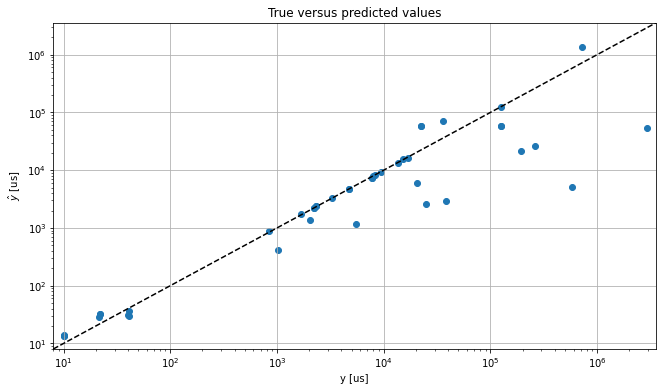

In [20]:
import pickle

results = pickle.load(open('gpu-mangrove/results.pkl', 'rb'))
fig, ax1 = plt.subplots(1,1,figsize=(10.8,6))

guide_min = results['y_true'].min()*0.8
guide_max = results['y_true'].max()*1.2
ax1.scatter(results['y_true'], results['y_pred'])
ax1.plot([guide_min,guide_max], [guide_min,guide_max], '--', label='', color='black')
ax1.set_xlabel('y [us]')
ax1.set_ylabel(r'$\^y$ [us]')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_ylim([guide_min,guide_max])
ax1.set_xlim([guide_min,guide_max])
ax1.set_title("True versus predicted values")
ax1.grid()

# Task 3.3 - Create and Evaluate Simple ML Model

1. Complete the simple prediction model in the next cell. Select parameters for your learning algorithm. You may use other regressors than random forest.
    * https://scikit-learn.org/stable/modules/svm.html#regression
    * https://scikit-learn.org/stable/modules/ensemble.html
2. Use the any sample datebase you want for this task. The  `sample_db` variable must point te the sample database you want to use.
3. Examine the model and test scores

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

sample_db = 'gpu-mangrove/data/power_samples_T4.db'

print("Reading samples..")
conn = sqlite3.Connection(sample_db)
samples = pd.read_sql_query(
    'select * from samples',
    conn, index_col=['bench','app','dataset','name'])

# Samples can be filtered by index
# This example gets all entry in which the index 1 (app) is equal to 'kmeans'
# samples = samples[samples.index.get_level_values(1) == 'kmeans']

# Store features without time column (!) in X
X = samples[samples.columns[1:-1]]
# Use y = samples['time'] when predicting time
y = samples['power']

print("Dividing into train and test set..")
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=17)

# Referr to https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor

###### This section is to be solved by you!
regr = RandomForestRegressor(n_estimators=100,
                             criterion='mse',
                             max_depth=None,
                             random_state=17)

##### End of Section

print("Train model..")
regr.fit(X_train, y_train)
y_predict = regr.predict(X_test)
results = pd.DataFrame()
results['y_true'] = y_test
results['y_pred'] = regr.predict(X_test)
results['mse'] = (y_test - y_predict)**2
results['mae'] = np.abs(y_test - y_predict)
results['mape'] = 100 * np.abs(y_test - y_predict)/y_test
print('Mean errors:')
print(results.mean())


Reading samples..
Dividing into train and test set..
Train model..
Mean errors:
y_true    61.977306
y_pred    63.589746
mse       13.310794
mae        2.651764
mape       5.494394
dtype: float64


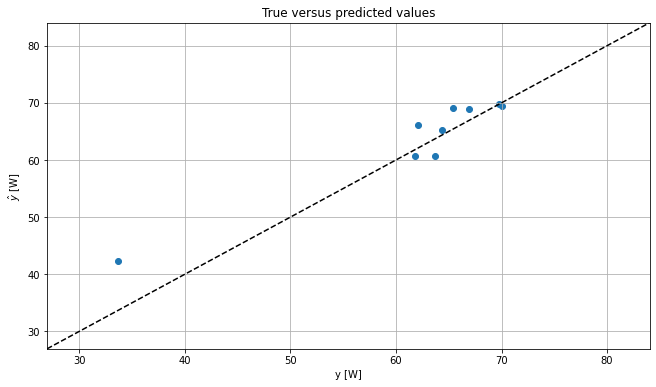

In [23]:
fig, ax1 = plt.subplots(1,1,figsize=(10.8,6))

guide_min = results['y_true'].min()*0.8
guide_max = results['y_true'].max()*1.2
ax1.scatter(results['y_true'], results['y_pred'])
ax1.plot([guide_min,guide_max], [guide_min,guide_max], '--', label='', color='black')
ax1.set_xlabel('y [W]')
ax1.set_ylabel(r'$\^y$ [W]')
# Log scale usually helps for time prediction as execution time can have a wide range of values
# ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.set_ylim([guide_min,guide_max])
ax1.set_xlim([guide_min,guide_max])
ax1.set_title("True versus predicted values")
ax1.grid()

# Task 3.4 [optional] - Create ML Model using GPU Mangrove dataset

Develop the simple modelling approach a further.
* Test different sets of hyper-parameters. Cross-validation can be helpful.  
  https://scikit-learn.org/stable/modules/grid_search.html
* The quality of the prediction can be measured using different error metrics. Which metrics help best to understand the quality of the predictions?